# An Analysis of the Enron Email Dataset

In [55]:
import multiprocessing
import seaborn as sns
import email
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wordcloud
import os, sys, email,re
import numpy as np 
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
import wordcloud

# Network analysis
import networkx as nx
#import nxviz as nv

# NLP
from nltk.tokenize.regexp import RegexpTokenizer

from subprocess import check_output

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import LatentDirichletAllocation

import gensim
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.stem.porter import PorterStemmer
from nltk import corpus
import pyLDAvis
from pyLDAvis import gensim
import pandas as pd
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import re
import spacy

# Introduction to the Dataset

https://www.kaggle.com/wcukierski/enron-email-dataset

The used dataset was obtained by the Federal Energy Regulatory Commission during its investigation of the Enron Collapse. The dataset encompasses approximately 500,000 emails from over 150 employees of the Enron Corporation.

After a decade of prosperous growth for the company during the 1990s, Enron came under pressure from both shareholders and the company's executives to increase profits to their once high-numbers.

In order to attempt to hide expenses, and make profits seem higher than they actually were, executives relied on an accounting technique called "Mark-to-market". This is unfortunately illegal. In addition to this the company began to move its more risky and troubling divisions of the corporation to "Special Purpose Entities" (SPEs). This is also unfortunately illegal as it made Enron's losses look much less than they were in reality. 

By mid 2001 a number of analysts had begun to dig into Enron's financial reports and uncover these massive discrepencies. First an internal investigation would be launched, then an investigation by the Security and Excange Commission (SEC), all while Enron's share prices continued to take from a mid-2000 high of 90 dollars to less than one dollar by the end of 2001. 

On December 2nd, 2001, Enron officially filed for Chapter 11 Bankruptcy, along with this many executives were indicted. During the impending investigation did the emails that compose this dataset come to light.

### Notes with the Dataset

Due to its peculiar nature, as will be shown below, I neither had traditional research questions nor normal numeric outputs for most of my code. Most of the challenge in working with this dataset came in transforming the monstrous 'message' column into a usable dataframe.

I chose this dataset by reccommendation from Dr. Bixler. I had originally intended to work with a dataset that was similar in structure but instead focused on spam in text messages. That one however, was quite short, and he directed my attention instead to this dataset.

Although it seems that there would be a considerable amount of ethical questions over the use of this dataset, I will simply choose to reflect those questions. This dataset was originally retrieved as part of an investigation by the SEC and other government bodies. This information only came to light as a response to their wrong-doing, so I really don't feel bad about going through these people's personal information.

# Initialization of Dataset

In [56]:
emails_df = pd.read_csv('../data/emails.csv')

In [57]:
emails_df.head()

file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...

In [58]:
emails_df.shape

(517401, 2)

This is a relatively simple dataset for a project like this, as it only has two columns. The difficulty however, comes in cleaning up the message column. 

In [59]:
#Printing of example message
#This entire text block is just one element of the message column, there are 500,000 rows that all look like this. 
print(emails_df.loc[1]['message'])

Message-ID: <15464986.1075855378456.JavaMail.evans@thyme>
Date: Fri, 4 May 2001 13:51:00 -0700 (PDT)
From: phillip.allen@enron.com
To: john.lavorato@enron.com
Subject: Re:
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Traveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.

As far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not.  Too often the

As shown above this column is composed of thousands of long, messy, strings. These strings contain nearly all the data about the email, including the ID, date, Sender, Reciever, and Subject, in a semi-organized manner.

Our challenge here is seperating all of these categories up into multiple columns, so that we are actually able to do some work with this datset.

# Tidying

In [60]:
message = emails_df.loc[1]['message']
e = email.message_from_string(message)

e.items()
#This code block is used to seperate all of the headers from each category into seperate items
#Will be integral in the seperation of columns

[('Message-ID', '<15464986.1075855378456.JavaMail.evans@thyme>'),
 ('Date', 'Fri, 4 May 2001 13:51:00 -0700 (PDT)'),
 ('From', 'phillip.allen@enron.com'),
 ('To', 'john.lavorato@enron.com'),
 ('Subject', 'Re:'),
 ('Mime-Version', '1.0'),
 ('Content-Type', 'text/plain; charset=us-ascii'),
 ('Content-Transfer-Encoding', '7bit'),
 ('X-From', 'Phillip K Allen'),
 ('X-To', 'John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>'),
 ('X-cc', ''),
 ('X-bcc', ''),
 ('X-Folder', "\\Phillip_Allen_Jan2002_1\\Allen, Phillip K.\\'Sent Mail"),
 ('X-Origin', 'Allen-P'),
 ('X-FileName', 'pallen (Non-Privileged).pst')]

In [61]:
#Example of how to retrieve one category
e.get('Date')

'Fri, 4 May 2001 13:51:00 -0700 (PDT)'

In [62]:
#Here we can isolate the message contain in the email
e.get_payload()

"Traveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.\n\nAs far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not.  Too often the presenter speaks and the others are quiet just waiting for their turn.   The meetings might be better if held in a round table discussion format.  \n\nMy suggestion for where to go is Austin.  Play golf and rent a ski boat and jet ski's.  Flying somewhere takes too much time.\n"

In [63]:
#These functions have been written in order to help split the individual parts of the message column up.

#Get the main message from the message column, the beef of the email
def get_text_from_email(msg): 
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

#Seperates multiple email addresses when they occur in messages.
def split_email_addresses(line):
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

#Returns a single row split out from each message
def get_row(Series, row_num):
    result = pd.Series(index=Series.index)
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        message_words = message_words[row_num]
        result.iloc[row] = message_words
    return result

In [64]:
#This block utilizes the above functions to split the contents of the message column up.

#Puts the emails into a list email object
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)


# Get fields from email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]
    
# Gets content from emails
emails_df['content'] = list(map(get_text_from_email, messages))


# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages

emails_df.head()

file                                     Message-ID  \
0     allen-p/_sent_mail/1.  <18782981.1075855378110.JavaMail.evans@thyme>   
1    allen-p/_sent_mail/10.  <15464986.1075855378456.JavaMail.evans@thyme>   
2   allen-p/_sent_mail/100.  <24216240.1075855687451.JavaMail.evans@thyme>   
3  allen-p/_sent_mail/1000.  <13505866.1075863688222.JavaMail.evans@thyme>   
4  allen-p/_sent_mail/1001.  <30922949.1075863688243.JavaMail.evans@thyme>   

                                    Date                       From  \
0  Mon, 14 May 2001 16:39:00 -0700 (PDT)  (phillip.allen@enron.com)   
1   Fri, 4 May 2001 13:51:00 -0700 (PDT)  (phillip.allen@enron.com)   
2  Wed, 18 Oct 2000 03:00:00 -0700 (PDT)  (phillip.allen@enron.com)   
3  Mon, 23 Oct 2000 06:13:00 -0700 (PDT)  (phillip.allen@enron.com)   
4  Thu, 31 Aug 2000 05:07:00 -0700 (PDT)  (phillip.allen@enron.com)   

                          To    Subject Mime-Version  \
0     (tim.belden@enron.com)                     1.0   
1  (john.lavorato@enron.com)        Re:          1.0   
2   (leah.arsdall@enron.com)   Re: test          1.0   
3    (randall.gay@enron.com)                     1.0   
4     (greg.piper@enron.com)  Re: Hello          1.0   

                   Content-Type Content-Transfer-Encoding           X-From  \
0  text/plain; charset=us-ascii                      7bit  Phillip K Allen   
1  text/plain; charset=us-ascii                      7bit  Phillip K Allen   
2  text/plain; charset=us-ascii                      7bit  Phillip K Allen   
3  text/plain; charset=us-ascii                      7bit  Phillip K Allen   
4  text/plain; charset=us-ascii                      7bit  Phillip K Allen   

                                                X-To X-cc X-bcc  \
0           Tim Belden <Tim Belden/Enron@EnronXGate>              
1  John J Lavorato <John J Lavorato/ENRON@enronXg...              
2                                   Leah Van Arsdall              
3                                      Randall L Gay              
4                                         Greg Piper              

                                            X-Folder X-Origin  \
0  \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...  Allen-P   
1  \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...  Allen-P   
2    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  Allen-P   
3    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  Allen-P   
4    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  Allen-P   

                    X-FileName  \
0  pallen (Non-Privileged).pst   
1  pallen (Non-Privileged).pst   
2                   pallen.nsf   
3                   pallen.nsf   
4                   pallen.nsf   

                                             content     user  
0                          Here is our forecast\n\n   allen-p  
1  Traveling to have a business meeting takes the...  allen-p  
2                     test successful.  way to go!!!  allen-p  
3  Randy,\n\n Can you send me a schedule of the s...  allen-p  
4                Let's shoot for Tuesday at 11:45.    allen-p

Its not perfect, some optimizing could be done with date or even some of the X-To elements, but most of the data has now been neatly split into columns for each of the categories laid out in the original message string.

# Exploratory Analysis

### Folder Analysis

In [66]:
print("number of folders: ", emails_df.shape[0])
print("number of unique folders: ", emails_df['X-Folder'].unique().shape[0])

number of folders:  517401
number of unique folders:  5336


In [67]:
unique_emails = pd.DataFrame(emails_df['X-Folder'].value_counts())
unique_emails.reset_index(inplace=True)


unique_emails.columns = ['folder_name', 'count']
# top 20 folders
unique_emails.iloc[:20,:]

folder_name  count
0    \Kay_Mann_June2001_1\Notes Folders\All documents   6639
1    \Tanya_Jones_Dec2000\Notes Folders\All documents   5934
2   \Jeff_Dasovich_June2001\Notes Folders\All docu...   5637
3   \Sara_Shackleton_Dec2000_June2001_1\Notes Fold...   5211
4   \Vincent_Kaminski_Jun2001_1\Notes Folders\All ...   5066
5   \Kay_Mann_June2001_2\Notes Folders\Discussion ...   4956
6   \Jeff_Dasovich_Dec2000\Notes Folders\All docum...   4660
7             \Kay_Mann_June2001_3\Notes Folders\Sent   4440
8       \Kay_Mann_June2001_4\Notes Folders\'sent mail   4220
9   \Mark_Taylor _Dec_2000\Notes Folders\All docum...   4022
10  \Vincent_Kaminski_Jun2001_2\Notes Folders\Disc...   3980
11  \Jeff_Dasovich_June2001\Notes Folders\Notes inbox   3535
12  \Steven_Kean_June2001_4\Notes Folders\Discussi...   3434
13  \Tanya_Jones_June2001\Notes Folders\All documents   3365
14    \kate symes 6-27-02\Notes Folders\All documents   3221
15  \kate symes 6-27-02\Notes Folders\Discussion t...   3065
16     \Tanya_Jones_Dec2000\Notes Folders\Notes inbox   2975
17  \Sara_Shackleton_Dec2000_June2001_2\Notes Fold...   2944
18  \Darren_Farmer_Dec2000\Notes Folders\All docum...   2838
19            \Tanya_Jones_Dec2000\Notes Folders\Sent   2633

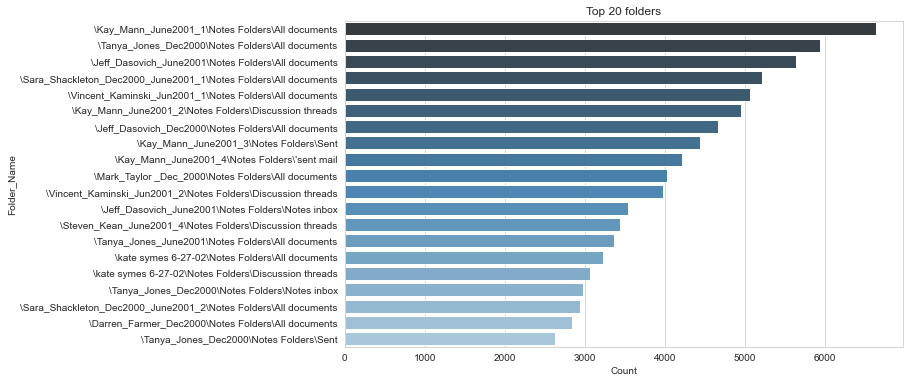

In [68]:
plt.figure(figsize=(10,6))
sns.barplot(x='count', y='folder_name', data=unique_emails.iloc[:20, :], palette="Blues_d")
plt.title("Top 20 folders")
plt.xlabel("Count")
plt.ylabel("Folder_Name")
plt.show()

Above I created a visualization of the various folders that our emails are placed into. We can see at the very top that we have a folder called Kay Mann June 2001 with over 6000 emails in it. 

### User Analysis

In [69]:
top_20 = pd.DataFrame(emails_df['user'].value_counts()[:20])
top_20.reset_index(inplace=True)
top_20.columns = ["Employee_name", "Counts"]
top_20

Employee_name  Counts
0     kaminski-v   28465
1     dasovich-j   28234
2         kean-s   25351
3         mann-k   23381
4        jones-t   19950
5   shackleton-s   18687
6       taylor-m   13875
7       farmer-d   13032
8      germany-c   12436
9         beck-s   11830
10       symes-k   10827
11       nemec-g   10655
12       scott-s    8022
13      rogers-b    8009
14        bass-e    7823
15     sanders-r    7329
16    campbell-l    6490
17     shapiro-r    6071
18      guzman-m    6054
19         lay-k    5937

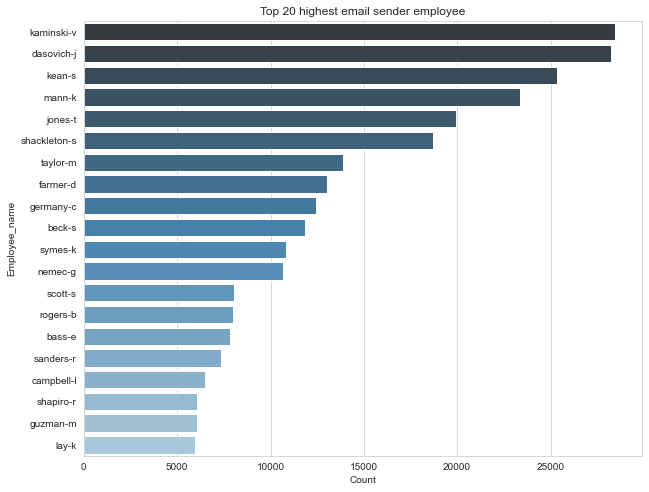

In [70]:
plt.figure(figsize=(10,8))

sns.barplot(y="Employee_name", x="Counts", data=top_20, palette="Blues_d")
plt.title("Top 20 highest email sender employee")
plt.xlabel("Count")
plt.ylabel("Employee_name")
plt.show()

The most emails, as shown in the graph above, were sent by Kaminski V, only a short amount behind them were Dasovich J. I think the drop off in total email is quite intriguing as there are four people who make up over a fifth of this dataset. Considering how monstrous this dataset is in size I would say that is quite suprising. 

### Subject/Message Word Count Analysis

In [71]:
# Count words in Subjects and content
tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')
emails_df['subject_wc'] = emails_df['Subject'].map(lambda x: len(tokenizer.tokenize(x)))
emails_df['content_wc'] = emails_df['content'].map(lambda x: len(tokenizer.tokenize(x)))

In [72]:
grouped_by_people = emails_df.groupby('user').agg({
        'content': 'count', 
        'subject_wc': 'mean',
        'content_wc': 'mean',
    })
grouped_by_people.rename(columns={'content': 'N emails', 
                                  'subject_wc': 'Subject word count', 
                                  'content_wc': 'Content word count'}, inplace=True)
grouped_by_people.sort_values('N emails', ascending=False).head()

N emails  Subject word count  Content word count
user                                                        
kaminski-v     28465            4.217530          255.906025
dasovich-j     28234            5.237373          603.393391
kean-s         25351            4.959331          490.837561
mann-k         23381            4.211796          207.195501
jones-t        19950            4.748221          185.462607

sns.pairplot(grouped_by_people.reset_index(), hue='user')

Although the above output does produce a desired set of graphs, it is plagued by a slew of error messages and is quite small and hard to see, so I have made it larger and cropped it below.

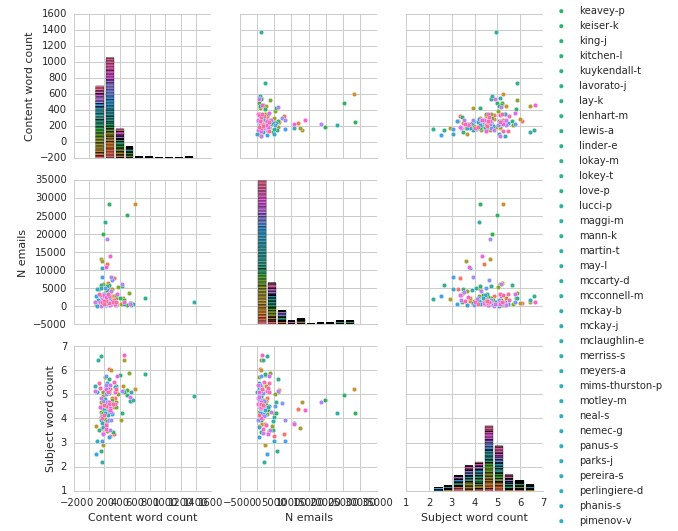

That's better.

In a series of graphs this analyzes the number of each persons emails along with their subject word count and message word count.

### Network Analysis

Now for some cool stuff... cool stuff that kills my computer.

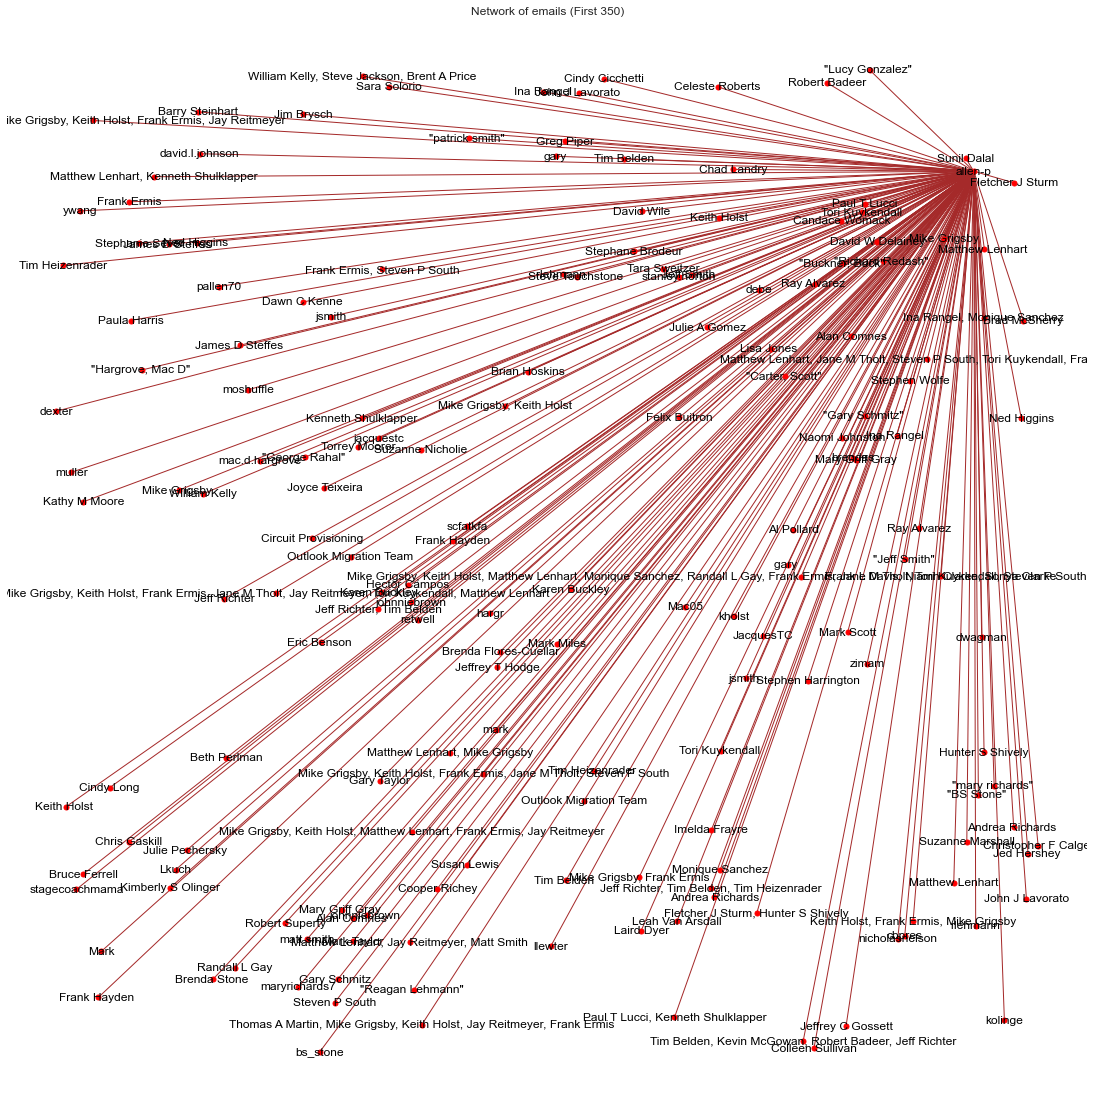

In [74]:
# The number of emails indicates a pattern,however it also important to consider the network
# that existed in the company.
dfnew = emails_df.head(n=350)

toUSER = []
for user in dfnew['X-To']:
    user = user.split('<')[0]
    user = user.split('@')[0]
    toUSER.append(user)
newlister = list(zip(dfnew['user'],toUSER))
datanewf = pd.DataFrame(newlister)
datanewf.columns = ['fromuser', 'touser']
G = nx.from_pandas_edgelist(datanewf, 'fromuser', 'touser')
plt.figure(figsize=(15,15))
pos = nx.draw_random(G, node_size = 25, node_color = 'red', edge_color = 'brown', with_labels = True)
plt.title('Network of emails (First 350)')
plt.show()


This graph visualizes the email network of users who have sent and received emails as individual nodes. Sadly, only the first 350 emails are displayed. Increasing this number further does two things: One it clutters the graph to the point where no discernable information can truly be gotten from it, and two it takes forever to construct.

While trying out this graph at a greater volume the Python task on my PC eventually began to eat up over 15 GB of ram before I just shut the operation down.

As is visible in the graph the central node is Allen P, and all of the other nodes trace back to him. This would of course change if another set of emails was examined, perhaps even leaving the graph with more than one center nodes.

### Aditional Network Analysis 

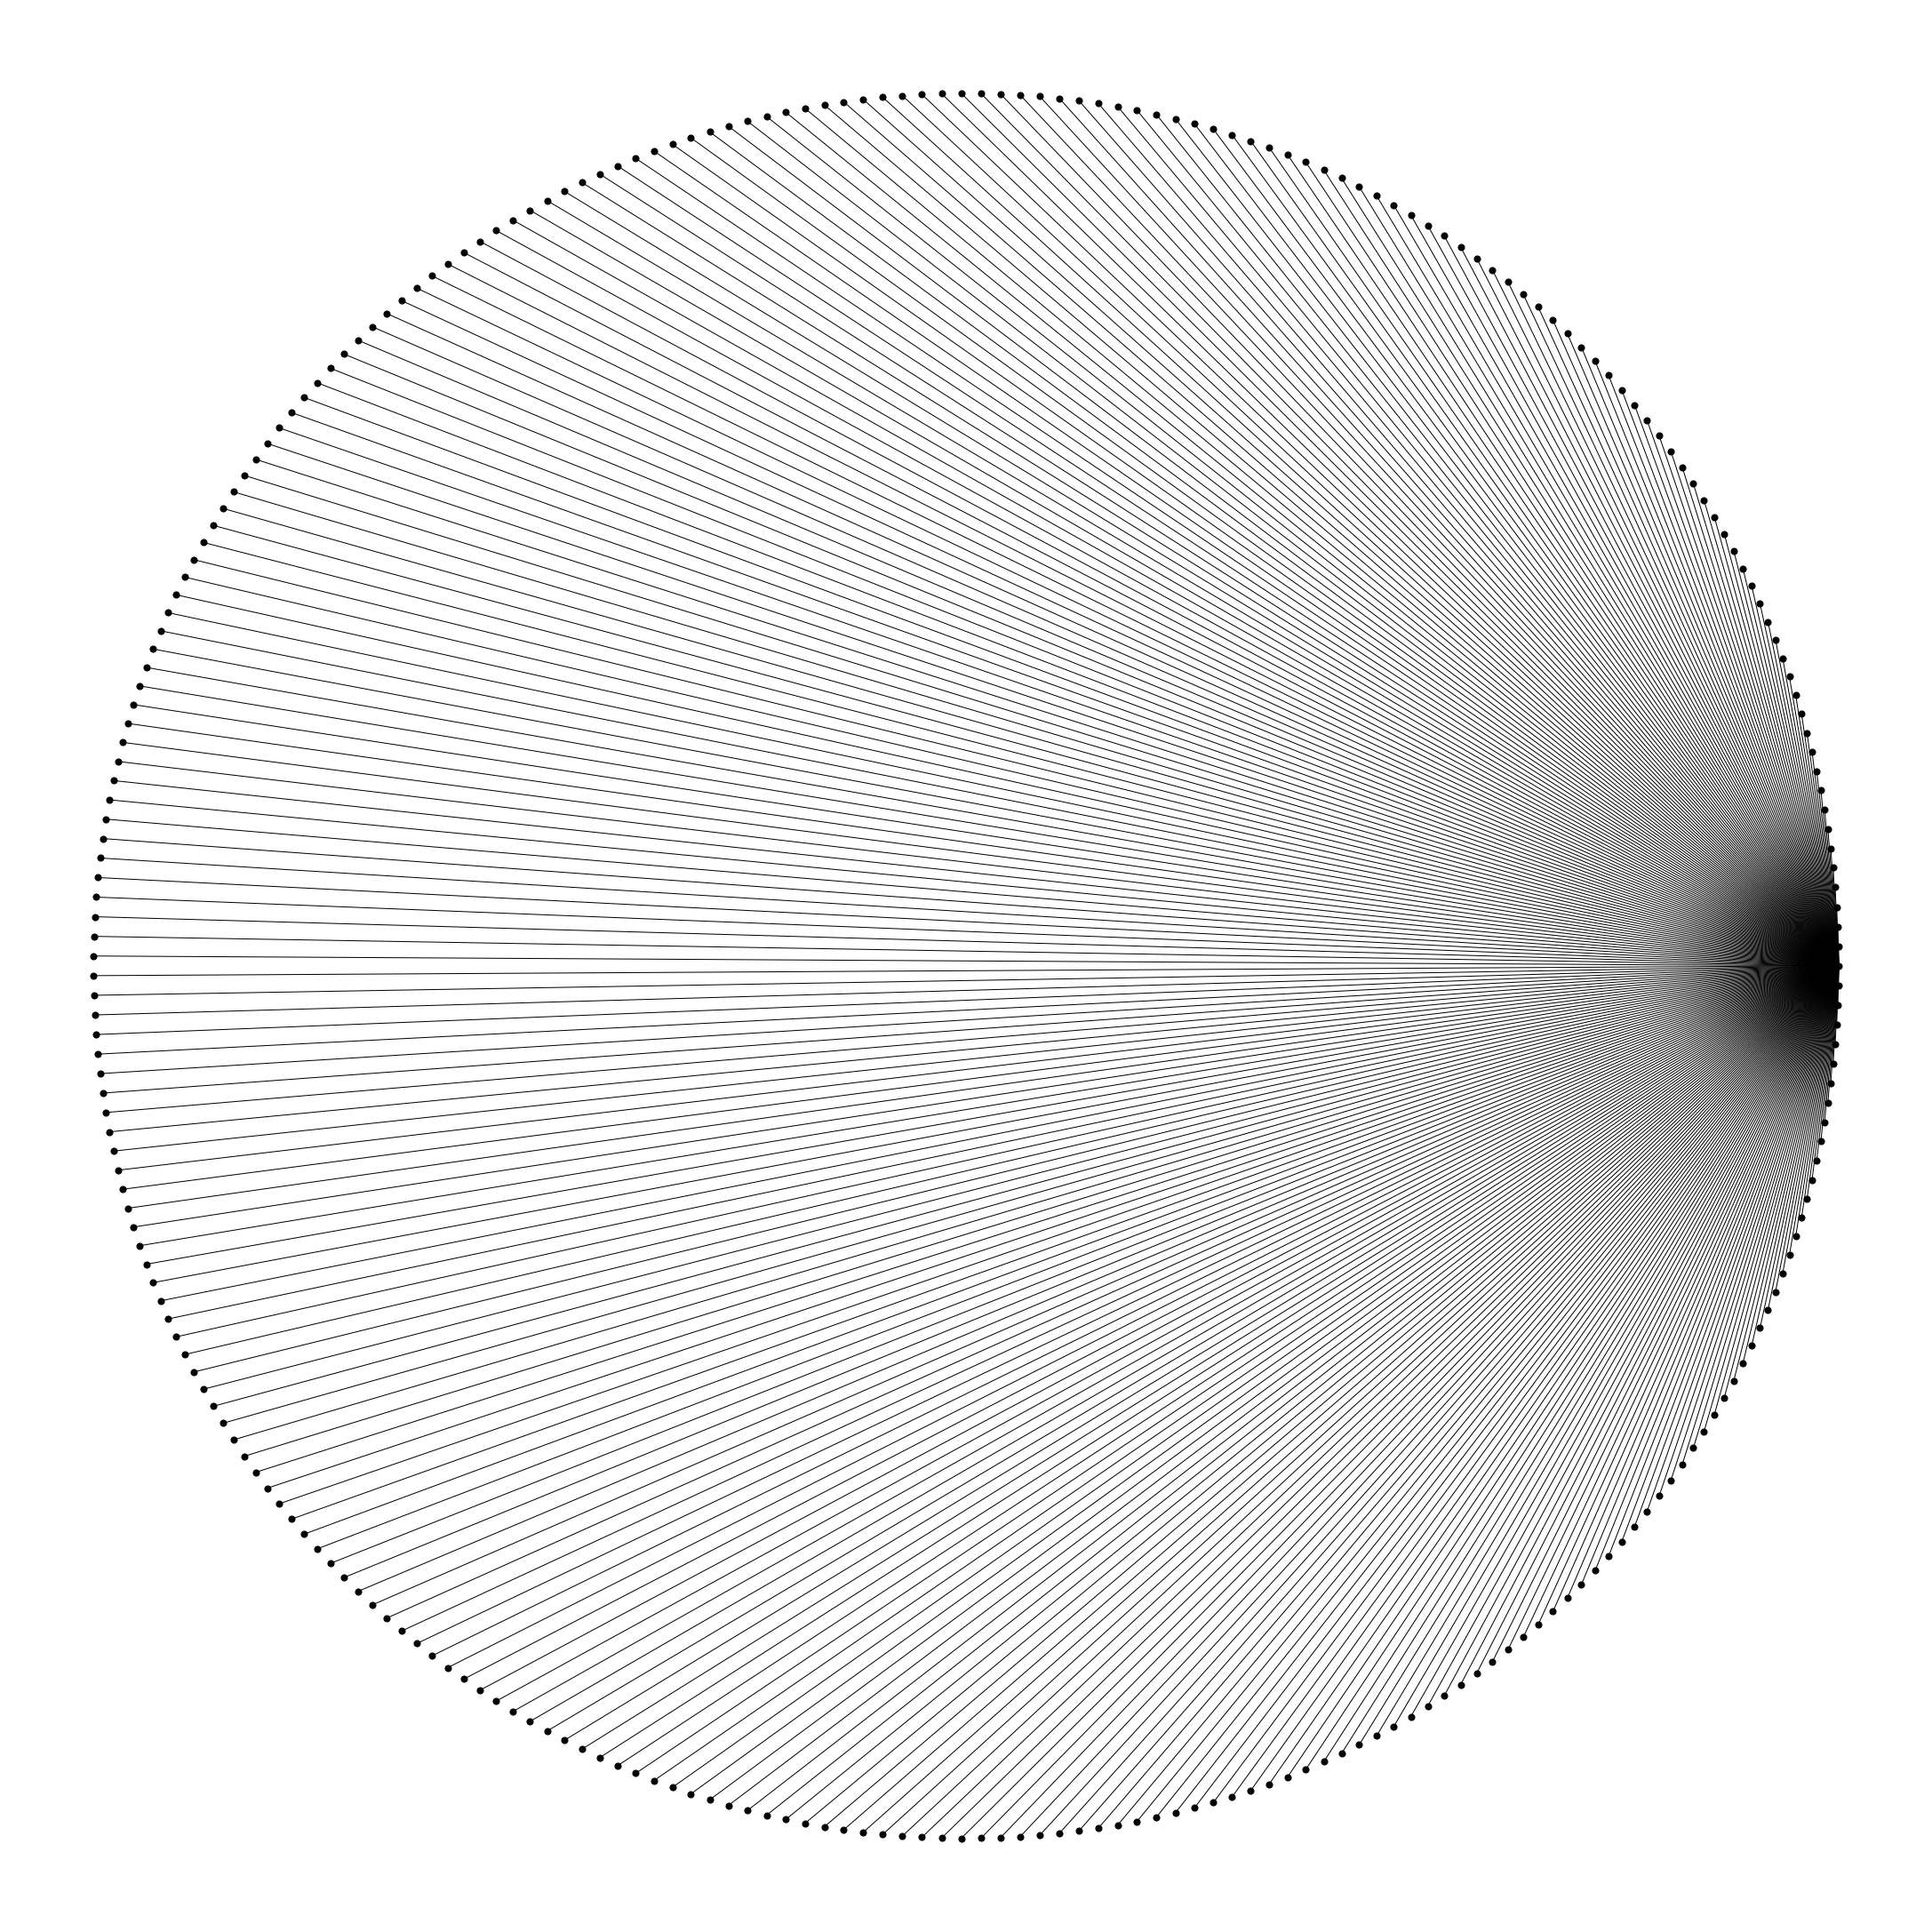

In [75]:
dfnew = emails_df.head(1000)

toUSER = []
for user in dfnew['X-To']:
    user = user.split('<')[0]
    user = user.split('@')[0]
    toUSER.append(user)
newlister = list(zip(dfnew['user'],toUSER))
datanewf = pd.DataFrame(newlister)
datanewf.columns = ['fromuser', 'touser']
G = nx.from_pandas_edgelist(datanewf, 'fromuser', 'touser')
plt.figure(figsize=(30,30))
pos = nx.draw_circular(G, node_size = 50, node_color = 'black', edge_color = 'black', with_labels = False)
plt.show()


This is similar to the previous graph, in which it treats each user as a node and tracks it back to a central point. The central point throughout the first 1,000 emails is once again Allen P. This again would not stay the same if the full dataset had been visualized, instead this graph would turn into a giant messy black ball. 

### World Clouds

Finally, as more of a fun visualization than anything, I have constructed two word clouds depicted the highest usage words in both the subject and message body column.

(-0.5, 799.5, 599.5, -0.5)

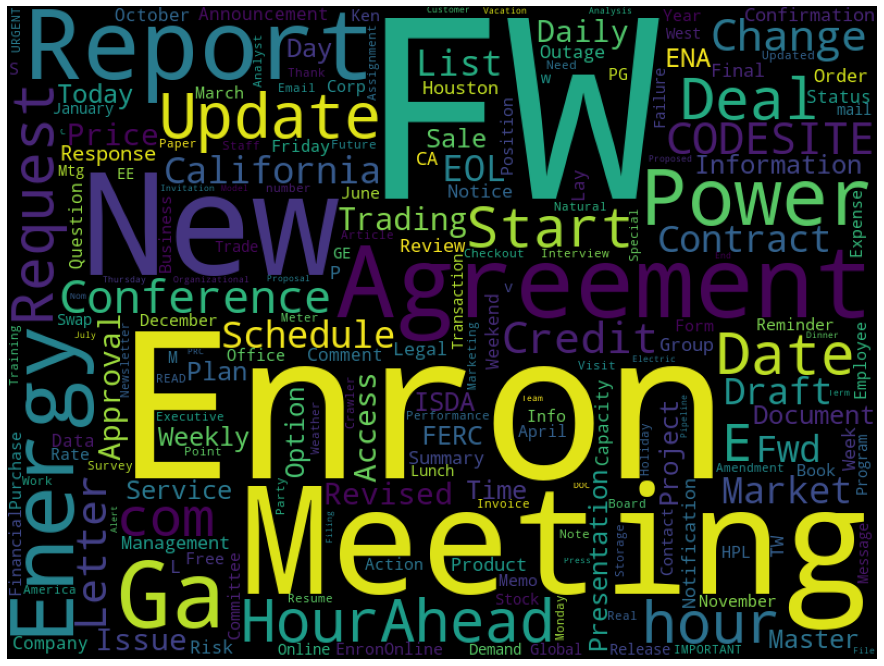

In [89]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

subjects = ' '.join(emails_df['Subject'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS,
                         collocations=False).generate(subjects)
ax.imshow(wc)
ax.axis("off")

(-0.5, 799.5, 599.5, -0.5)

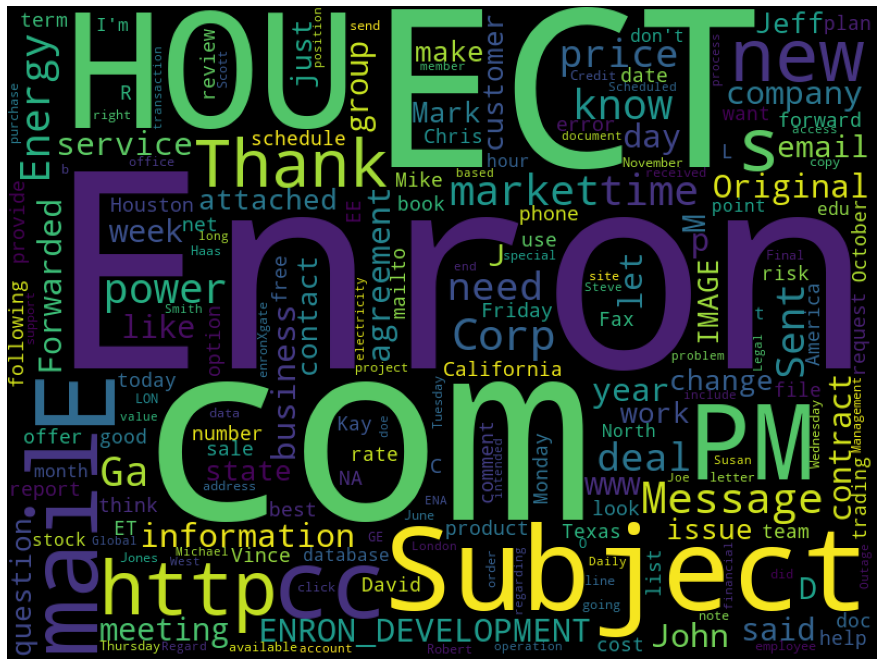

In [90]:
contents = ' '.join(emails_df.sample(1000)['content'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS,
                         collocations=False).generate(contents)
ax.imshow(wc)
ax.axis("off")

# Machine Learning

In [102]:
def clean(text):
    stop = set(stopwords.words('english'))
    stop.update(("to","cc","subject","http","from","sent","aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa", "www", "com", "x", "u", "e"))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    porter= PorterStemmer()
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    
    return normalized

In [103]:
analysis_df=emails_df[['From', 'To', 'Date','content']].dropna().copy()
analysis_df = analysis_df.loc[analysis_df['To'].map(len) == 1]
sub_df=analysis_df.sample(1000)

In [104]:
#sub_df["content"]=sub_df["content"].map(clean)
text_clean=[]
for text in sub_df['content']:
    text_clean.append(clean(text).split())

In [105]:
dictionary = corpora.Dictionary(text_clean)
text_term_matrix = [dictionary.doc2bow(text) for text in text_clean]

In [106]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(text_term_matrix, num_topics=4, id2word = dictionary, passes=30)

In [107]:
eng_stopwords = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.lower().split()
    words = [w for w in words if w not in eng_stopwords]
    return ' '.join(words)

analysis_df["clean_content"]=analysis_df.content.apply(clean_text)

In [108]:
wordvector = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.4, min_df=5)
short_analysis=analysis_df.sample(5000)
wordvector_fit = wordvector.fit_transform(short_analysis.clean_content)
feature = wordvector.get_feature_names()

In [109]:
N = 4
clf = KMeans(n_clusters=N, 
            max_iter=50, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(wordvector_fit)

In [110]:
wordvector_fit_2d = wordvector_fit.todense()
pca = PCA(n_components=2).fit(wordvector_fit_2d)
datapoint = pca.transform(wordvector_fit_2d)

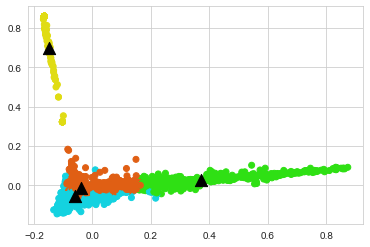

In [111]:
label = ["#e05f14", "#e0dc14", "#2fe014", "#14d2e0"]
color = [label[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

This output shows us four distinct clusters centered around four centroids by using the K-Means Clustering Algorithm. The clusters shown in yellow and green are much farther away from those of orange and blue on the graph, indciating a higher variance in their rseults.

In [112]:
print(ldamodel.print_topics(num_topics=4, num_words=10))


[(0, '0.048*"td" + 0.043*"font" + 0.017*"size" + 0.017*"align" + 0.015*"b" + 0.010*"br" + 0.009*"tr" + 0.009*"right" + 0.008*"nbsp" + 0.007*"class"'), (1, '0.057*"enron" + 0.047*"ect" + 0.022*"hou" + 0.011*"corp" + 0.008*"pm" + 0.008*"please" + 0.006*"na" + 0.005*"development" + 0.005*"thanks" + 0.005*"agreement"'), (2, '0.009*"enron" + 0.009*"message" + 0.007*"original" + 0.006*"pm" + 0.006*"week" + 0.005*"know" + 0.005*"get" + 0.004*"vince" + 0.004*"thursday" + 0.004*"matthew"'), (3, '0.007*"market" + 0.005*"price" + 0.005*"energy" + 0.005*"please" + 0.005*"enron" + 0.004*"gas" + 0.004*"transaction" + 0.004*"power" + 0.004*"would" + 0.004*"u"')]


The above output shows the most frequent topics retrieved from a Topic Model algorithm. As would be expected from a company like Enron, words such as gas, power, or energy all show up here. We also see a large amount of standard email ettiquette, such as please and thanks. 

# General Conclusions

As stated in the beginning of this notebook I did not believe that I had a set-in-stone array of research questions that I wanted to answer like many other people did with their projects. Through explorative analysis and toying with the dataset I was able to find questions and then subsequently answer them along the way.

Questions like:
    - Who was the biggest sender and reciever of male at the company?
    - What topics did these emails generally cover?
    - What language was used the most often across all emails?
    - How did Enron catalogue these emails in their system?
    
I feel that throughout my work with this dataset I have sufficiently answered each of these questions to my best capacity. If given more time to work with this dataset there are a number of things that I could imagine myself trying to do, including but not limited to:

Answering:
    - Who is the largest person of interest, based not on sent/recieved count, but on language used
            I feel this would be interesting as this dataset was siezed as part of a criminal investigation.
    - Putting in more work with date/time analysis of the datset. Although I had tried this for a while I could not get the modules fully working and would love to go back for another attempt if time were to allow. 
    - Searching for members of the dataset who were eventually convicted/appeared often in the media, and seeing how their language differed from the rest of the crowd.
    - Run more accurate tests, as although I am satisfied with my results, some were produced with a small sample size, due to the sheer total size of the dataset.